In [1]:
### PREREQUISTIES
### (many used only in one notebook...)

import os
import pandas as pd
import numpy as np
import logging ### to monitor the code
from bs4 import BeautifulSoup
import pickle
import math
import random
import sys
import csv
import unicodedata
import requests
import re

import nltk
from nltk.collocations import *

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.manifold import TSNE

from scipy import stats

import xml.etree.cElementTree as ET
from urllib.request import urlopen

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
from google.oauth2 import service_account # based on google-auth library
import sddk

In [2]:
#!pip install anda
#from anda import gr ### the import takes substantial time, since it import a +600MB file containing ancient Greek dictionary

In [3]:
### not neccessary for reading the data, just for exporting them to sciencedata.dk
conf = sddk.configure()

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [4]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:

# (1) read the file and parse its content
file_data = conf[0].get(conf[1] + "ServiceAccountsKey.json").json()
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)
# (5) establish connection with spreadsheets specified by their url
PIA_data = gc.open_by_url("https://docs.google.com/spreadsheets/d/1KxOx7Be9fj3lDcEPgQhQ-Iqcn9p367-MMD6RMXe8rks/edit?usp=sharing")
PIA_overview = gc.open_by_url("https://docs.google.com/spreadsheets/d/1e94wyelg6dftQ4zxbq1xvwxWAI-BhcYXtclDW-YTnrw/edit?usp=sharing")

In [5]:
### our data are located within a publicly available folder on sciencedata.dk
publicfolder = "31b393e2afe1ee96ce81869c7efe18cb"
c_aristotelicum = sddk.read_file("c_aristotelicum_repl.json", "df", publicfolder)
c_hippocraticum = sddk.read_file("c_hippocraticum_repl.json", "df", publicfolder)

reading file located in a public folder
reading file located in a public folder


**Make sure that you are connected to the kernel associated with our virtual environment . Go to `Kernel` -> `Change kernel` and choose `pia_venv`.**

In [84]:
#REQUIREMENTS

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD 
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

from gensim import corpora

In [5]:
# read the preprocessed versions of the datasets (including pain words replacements)
c_aristotelicum = pd.read_json("../data/c_aristotelicum_repl.json")
c_hippocraticum = pd.read_json("../data/c_hippocraticum_repl.json")

In [14]:
# replace work titles by their latin versions (on the basis of manual coding)
c_hip_metadata = pd.read_csv("../data/c_hip_metadata.csv")
c_hip_title_dict = dict(zip(c_hip_metadata["doc_id"], c_hip_metadata["title_latin"]))                     
c_hippocraticum["title"] = c_hippocraticum.apply(lambda row: c_hip_title_dict[row["doc_id"]], axis=1)

c_arist_metadata = pd.read_csv("../data/c_arist_metadata.csv")
c_arist_title_dict = dict(zip(c_arist_metadata["doc_id"], c_arist_metadata["title_latin"]))                     
c_aristotelicum["title"] = c_aristotelicum.apply(lambda row: c_arist_title_dict[row["doc_id"]], axis=1)

In [16]:
c_hippocraticum.head(5)

,filename,author,title,wordcount,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,tlg_epithet,clean_string,n_sentences,lemmatized_sentences,lemmata,lemmata_wordcount,lemmata_repl,lemmatized_sentences_repl
1039,tlg0627.tlg001.perseus-grc1.xml,Hippocrates,De prisca medicina,5534,tlg0627,tlg0627.tlg001,5-4 B.C.,-4,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,Medici,ὁπόσοι μὲν ἐπεχείρησαν περὶ ἰητρικῆς λέγειν ἢ ...,258,"[[ὁπόσος, ἐπιχειρέω, ἰητρικῆς, λέγω, γράφω, ὑπ...","[ὁπόσος, ἐπιχειρέω, ἰητρικῆς, λέγω, γράφω, ὑπό...",2613,"[ὁπόσος, ἐπιχειρέω, ἰητρικῆς, λέγω, γράφω, ὑπό...","[[ὁπόσος, ἐπιχειρέω, ἰητρικῆς, λέγω, γράφω, ὑπ..."
1040,tlg0627.tlg002.perseus-grc1.xml,Hippocrates,De aëre aquis et locis,7502,tlg0627,tlg0627.tlg002,5-4 B.C.,-4,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,Medici,"ἰητρικὴν ὅστις βούλεται ὀρθῶς ζητεῖν, τάδε χρὴ...",461,"[[ἰατρικός, βούλομαι, ζητέω, χρή, ποιέω], [πρῶ...","[ἰατρικός, βούλομαι, ζητέω, χρή, ποιέω, πρῶτος...",3470,"[ἰατρικός, βούλομαι, ζητέω, χρή, ποιέω, πρῶτος...","[[ἰατρικός, βούλομαι, ζητέω, χρή, ποιέω], [πρῶ..."
1041,tlg0627.tlg003.perseus-grc1.xml,Hippocrates,Prognosticon,5217,tlg0627,tlg0627.tlg003,5-4 B.C.,-4,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,Medici,τὸν ἰητρὸν δοκέει μοι ἄριστον εἶναι πρόνοιαν ἐ...,302,"[[ἰατρός, δοκέω, ἀγαθός, εἰμί, πρόνοια, ἐπιτηδ...","[ἰατρός, δοκέω, ἀγαθός, εἰμί, πρόνοια, ἐπιτηδε...",2503,"[ἰατρός, δοκέω, ἀγαθός, εἰμί, πρόνοια, ἐπιτηδε...","[[ἰατρός, δοκέω, ἀγαθός, εἰμί, πρόνοια, ἐπιτηδ..."
1042,tlg0627.tlg004.perseus-grc1.xml,Hippocrates,De diaeta in morbis acutis,6128,tlg0627,tlg0627.tlg004,5-4 B.C.,-4,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,Medici,"οἱ ξυγγράψαντες τὰς Κνιδίας καλεομένας γνώμας,...",373,"[[ξυγγράψαντες, Κνίδιος, καλέω, γνώμη, ὁποῖος,...","[ξυγγράψαντες, Κνίδιος, καλέω, γνώμη, ὁποῖος, ...",2926,"[ξυγγράψαντες, Κνίδιος, καλέω, γνώμη, ὁποῖος, ...","[[ξυγγράψαντες, Κνίδιος, καλέω, γνώμη, ὁποῖος,..."
1043,tlg0627.tlg005.perseus-grc1.xml,Hippocrates,De diaeta acutorum (Sp.),5218,tlg0627,tlg0627.tlg005,5-4 B.C.,-4,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,Medici,"καῦσος γίγνεται, ὁκόταν ἀναξηρανθέντα τὰ φλέβι...",352,"[[καῦσος, γίγνομαι, ἀναξηρανθέντα, φλέβια, θερ...","[καῦσος, γίγνομαι, ἀναξηρανθέντα, φλέβια, θερι...",2855,"[καῦσος, γίγνομαι, ἀναξηρανθέντα, φλέβια, θερι...","[[καῦσος, γίγνομαι, ἀναξηρανθέντα, φλέβια, θερ..."


In [18]:
# make overview columns of individual terms accross documents
for pattern_tuple in keyterm_patterns:
    term = pattern_tuple[1] # eg. "λύπ*"
    c_aristotelicum[term] =  c_aristotelicum.apply(lambda row: row["lemmata_repl"].count(term), axis=1)
    c_hippocraticum[term] =  c_hippocraticum.apply(lambda row: row["lemmata_repl"].count(term), axis=1)
c_aristotelicum["terms_sum"] = c_aristotelicum.apply(lambda row: (row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]), axis=1)
c_hippocraticum["terms_sum"] = c_hippocraticum.apply(lambda row: (row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]), axis=1)

In [19]:
c_aristotelicum[["πόνο*", "ὀδύν*", "ἄλγ*", "λύπ*"]].sum()

πόνο*    103
ὀδύν*      3
ἄλγ*      34
λύπ*     406
dtype: int64

In [20]:
c_hippocraticum[["πόνο*", "ὀδύν*", "ἄλγ*", "λύπ*"]].sum()
#previous data: λύπ*      58; ἄλγ*     315; ὀδύν*    642; πόνο*    651

πόνο*    657
ὀδύν*    645
ἄλγ*     315
λύπ*      58
dtype: int64

In [23]:
for term in ["πόνο*", "ὀδύν*", "ἄλγ*", "λύπ*"]:
    c_aristotelicum[term + "_TF"] = c_aristotelicum.apply(lambda row: np.round(row[term] / row["wordcount"], 6), axis=1)
    c_hippocraticum[term + "_TF"] = c_hippocraticum.apply(lambda row: np.round(row[term] / row["wordcount"], 6), axis=1)
c_aristotelicum["TF_sum"] = c_aristotelicum.apply(lambda row: np.round((row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]) / row["wordcount"], 6), axis=1)
c_hippocraticum["TF_sum"] = c_hippocraticum.apply(lambda row: np.round((row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]) / row["wordcount"], 6), axis=1)

# Work types / document clustering

In [30]:
# add metadata for work categories
# we work 

c_hip_cat_dict_jouanna = dict(zip(c_hip_metadata["doc_id"], c_hip_metadata["work_category"]))
c_hip_cat_dict_craik = dict(zip(c_hip_metadata["doc_id"], c_hip_metadata["title_category_Craik"]))
c_hip_cat_dict_linka = dict(zip(c_hip_metadata["doc_id"], c_hip_metadata["work_category_linka"]))
c_hip_cat_dict_jouanna

{'tlg0627.tlg001': '(Anti)philosophical',
 'tlg0627.tlg002': 'Itinerant physician',
 'tlg0627.tlg003': 'Prognostics',
 'tlg0627.tlg004': 'Prognostics',
 'tlg0627.tlg005': 'Other',
 'tlg0627.tlg006': 'Epidemics',
 'tlg0627.tlg007': 'Surgical',
 'tlg0627.tlg008': 'Surgical',
 'tlg0627.tlg009': 'Surgical',
 'tlg0627.tlg010': 'Surgical',
 'tlg0627.tlg011': 'Surgical',
 'tlg0627.tlg012': 'Aphorisms',
 'tlg0627.tlg013': 'Other',
 'tlg0627.tlg014': 'Other',
 'tlg0627.tlg015': 'Epidemics',
 'tlg0627.tlg016': 'Other',
 'tlg0627.tlg017': 'Cnidan',
 'tlg0627.tlg018': 'Later',
 'tlg0627.tlg019': '(Anti)philosophical',
 'tlg0627.tlg020': 'Dietetics',
 'tlg0627.tlg021': 'Other',
 'tlg0627.tlg022': 'Other',
 'tlg0627.tlg023': 'Cnidan',
 'tlg0627.tlg024': 'Other',
 'tlg0627.tlg025': 'Other',
 'tlg0627.tlg026': 'Other',
 'tlg0627.tlg027': 'Itinerant physician',
 'tlg0627.tlg028': 'Other',
 'tlg0627.tlg029': 'Other',
 'tlg0627.tlg030': 'Other',
 'tlg0627.tlg031': 'Dietetics',
 'tlg0627.tlg032': 'Cnidan'

In [31]:
c_hippocraticum["work_cat_jouanna"] = c_hippocraticum.apply(lambda row: c_hip_cat_dict_jouanna[row["doc_id"]], axis=1)
c_hippocraticum["work_cat_craik"] = c_hippocraticum.apply(lambda row: c_hip_cat_dict_craik[row["doc_id"]], axis=1)
c_hippocraticum["work_cat_linka"] = c_hippocraticum.apply(lambda row: c_hip_cat_dict_linka[row["doc_id"]], axis=1)
c_hippocraticum.head(5)

,filename,author,title,wordcount,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,...,πόνο*,terms_sum,πόνο*_TF,ὀδύν*_TF,ἄλγ*_TF,λύπ*_TF,TF_sum,work_cat_jouanna,work_cat_craik,work_cat_linka
1039,tlg0627.tlg001.perseus-grc1.xml,Hippocrates,De prisca medicina,5534,tlg0627,tlg0627.tlg001,5-4 B.C.,-4,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,17,26,0.003072,0.000361,0.000181,0.001084,0.004698,(Anti)philosophical,Scientific principles,Theoretical
1040,tlg0627.tlg002.perseus-grc1.xml,Hippocrates,De aëre aquis et locis,7502,tlg0627,tlg0627.tlg002,5-4 B.C.,-4,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,1,2,0.000133,0.000133,0.000000,0.000000,0.000267,Itinerant physician,Scientific principles,Other
1041,tlg0627.tlg003.perseus-grc1.xml,Hippocrates,Prognosticon,5217,tlg0627,tlg0627.tlg003,5-4 B.C.,-4,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,15,45,0.002875,0.004025,0.001533,0.000192,0.008626,Prognostics,Cases and signs,Practical
1042,tlg0627.tlg004.perseus-grc1.xml,Hippocrates,De diaeta in morbis acutis,6128,tlg0627,tlg0627.tlg004,5-4 B.C.,-4,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,13,32,0.002121,0.002448,0.000653,0.000000,0.005222,Prognostics,"Nosology, pathology, therapy",Other
1043,tlg0627.tlg005.perseus-grc1.xml,Hippocrates,De diaeta acutorum (Sp.),5218,tlg0627,tlg0627.tlg005,5-4 B.C.,-4,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,12,39,0.002300,0.000958,0.003450,0.000767,0.007474,Other,"Nosology, pathology, therapy",Other


In [32]:
cats_jouanna = sorted(c_hippocraticum["work_cat_jouanna"].unique().tolist())
cats_jouanna

['(Anti)philosophical',
 'Aphorisms',
 'Cnidan',
 'Dietetics',
 'Epidemics',
 'Female medicine',
 'Itinerant physician',
 'Later',
 'Other',
 'Prognostics',
 'Surgical']

In [33]:
cats_craig = sorted(c_hippocraticum["work_cat_craik"].unique().tolist())
cats_craig

['Anatomy and physiology',
 'Cases and signs',
 'Guidance and ideals',
 'Gynaecology and embryology',
 'Nosology, pathology, therapy',
 'Scientific principles',
 'Surgery']

In [34]:
cats_linka = sorted(c_hippocraticum["work_cat_linka"].unique().tolist(), reverse=True)
cats_linka

['Theoretical', 'Practical', 'Other']

In [35]:
cat_dfs = {}
for category_column in ["work_cat_jouanna", "work_cat_craik", "work_cat_linka"]:
    cat_df = c_hippocraticum.groupby(category_column).sum().drop(['date_avr', 'date_manual', "λύπ*_TF", "ἄλγ*_TF", "ὀδύν*_TF", "πόνο*_TF", 'TF_sum'], axis=1)
    cat_df["N_docs"] = c_hippocraticum.groupby(category_column).size()
    for term in ["πόνο*", "ὀδύν*", "ἄλγ*", "λύπ*"]:
        cat_df[term + "_TF"] = cat_df.apply(lambda row: np.round(row[term] / row["wordcount"], 6), axis=1)
        cat_df[term + "_TF"] = cat_df.apply(lambda row: np.round(row[term] / row["wordcount"], 6), axis=1)
    cat_df["TF_sum"] = cat_df.apply(lambda row: np.round((row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]) / row["wordcount"], 6), axis=1)
    cat_dfs[category_column] = cat_df

In [36]:
cat_dfs["work_cat_linka"] = cat_dfs["work_cat_linka"].sort_index(ascending=False)
cat_dfs["work_cat_linka"]

,wordcount,n_sentences,lemmata_wordcount,λύπ*,ἄλγ*,ὀδύν*,πόνο*,terms_sum,N_docs,πόνο*_TF,ὀδύν*_TF,ἄλγ*_TF,λύπ*_TF,TF_sum
work_cat_linka,,,,,,,,,,,,,,
Theoretical,36495,2501,18452,11,16,25,175,227,4,0.004795,0.000685,0.000438,0.000301,0.006220
Practical,52044,5044,28942,5,106,122,172,405,5,0.003305,0.002344,0.002037,0.000096,0.007782
Other,244904,16911,123938,42,193,498,310,1043,43,0.001266,0.002033,0.000788,0.000171,0.004259


In [37]:
cat_dfs["work_cat_craik"]

,wordcount,n_sentences,lemmata_wordcount,λύπ*,ἄλγ*,ὀδύν*,πόνο*,terms_sum,N_docs,πόνο*_TF,ὀδύν*_TF,ἄλγ*_TF,λύπ*_TF,TF_sum
work_cat_craik,,,,,,,,,,,,,,
Anatomy and physiology,20295,1324,9570,2,15,32,28,77,7,0.001380,0.001577,0.000739,0.000099,0.003794
Cases and signs,33481,3025,18240,7,62,113,105,287,7,0.003136,0.003375,0.001852,0.000209,0.008572
Guidance and ideals,40499,3924,22013,9,86,38,112,245,11,0.002766,0.000938,0.002124,0.000222,0.006050
Gynaecology and embryology,73311,5289,40363,5,68,163,79,315,7,0.001078,0.002223,0.000928,0.000068,0.004297
"Nosology, pathology, therapy",70273,4726,35253,17,74,272,149,512,5,0.002120,0.003871,0.001053,0.000242,0.007286
Scientific principles,46689,3066,22668,17,8,5,161,191,7,0.003448,0.000107,0.000171,0.000364,0.004091
Surgery,48895,3102,23225,1,2,22,23,48,8,0.000470,0.000450,0.000041,0.000020,0.000982


In [38]:
cat_dfs.keys()

dict_keys(['work_cat_jouanna', 'work_cat_craik', 'work_cat_linka'])

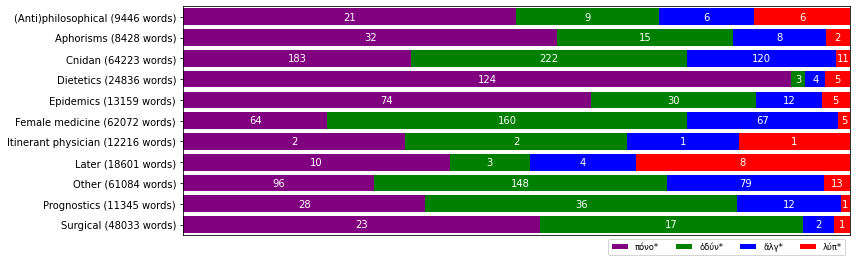

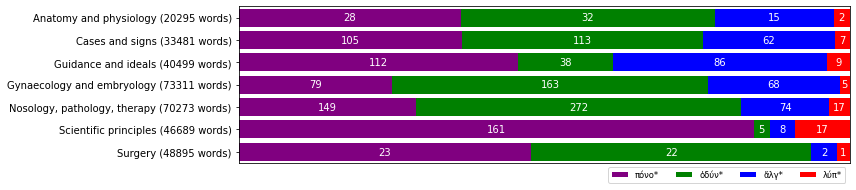

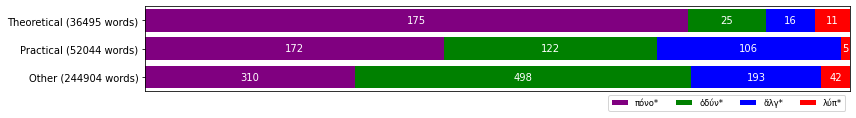

In [41]:
keys_figs_tups = []

for key in cat_dfs.keys():
    # extract the dataframe (in reverse order)
    c_hippocraticum_by_cat = cat_dfs[key][::-1]
    # prepare the data
    data, labels, counts, ratios = [], [], [], [] # prepare for empty lists 
    for n in range(len(c_hippocraticum_by_cat)):
        label = str(c_hippocraticum_by_cat.index[n]) + " (" + str(int(c_hippocraticum_by_cat.iloc[n]["wordcount"])) + " words)"
        labels.append(label)
        cat_counts = c_hippocraticum_by_cat.iloc[n][["πόνο*", "ὀδύν*", "ἄλγ*", "λύπ*"]].tolist()
        counts.append(cat_counts)
        cat_ratios = [val / c_hippocraticum_by_cat.iloc[n]["terms_sum"] * 100 for val in  cat_counts] # if val > 0]
        cat_ratios = [0 if math.isnan(x) else x for x in cat_ratios]
        ratios.append(cat_ratios)
    # extract the dataframe (in reverse order)
    counts = np.array(counts)
    ratios = np.array(ratios)
    ratios_cum = ratios.cumsum(axis=1)
    category_colors = ["Purple", "Green", "Blue", "Red"]
    terms = ["πόνο*", "ὀδύν*", "ἄλγ*", "λύπ*"]

    fig, ax = plt.subplots(figsize=(12, (len(c_hippocraticum_by_cat) / 4) + 1), tight_layout=True)
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)

    ax.set_xlim(0, np.sum(ratios, axis=1).max())
    ax.set_ylim(-0.5, len(c_hippocraticum_by_cat) - 0.5)

    for i, (term, color) in enumerate(zip(terms, category_colors)):
              widths = ratios[:, i]
              texts = counts[:, i]
              starts = ratios_cum[:, i] - widths
              ax.barh(labels, widths, left=starts,
                      label=term, color=color)
              xcenters = starts + widths / 2
              for y, (x, c) in enumerate(zip(xcenters, texts)):
                  if int(c) > 0:
                    ax.text(x, y, str(int(c)), ha='center', va='center', color='white')
                  else:
                    ax.text(x, y, "", ha='center', va='center', color='white')
    ax.legend(ncol=len(terms), bbox_to_anchor=(1, 0), fontsize='small') # loc='lower left'
    
    #ax.set_title("Pain words ratios by work categories by " + key.rpartition("_")[2].capitalize())
    keys_figs_tups.append((key, fig))



In [45]:
for key_fig in keys_figs_tups:
    key_fig[1].savefig("../figures/c_hip_ratios_by_cat_{0}.png".format(key_fig[0].rpartition("_")[2]))

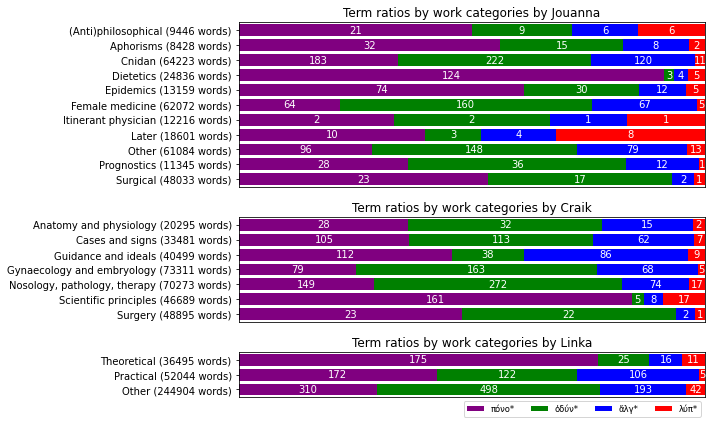

In [46]:
fig, [ax1, ax2, ax3],  = plt.subplots(3, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [11, 7, 3]}, tight_layout=True)

for key, ax in zip(cat_dfs.keys(), [ax1, ax2, ax3]):
    # extract the dataframe (in reverse order)
    c_hippocraticum_by_cat = cat_dfs[key][::-1]
    # prepare the data
    data, labels, counts, ratios = [], [], [], [] # prepare for empty lists 
    for n in range(len(c_hippocraticum_by_cat)):
        label = str(c_hippocraticum_by_cat.index[n]) + " (" + str(int(c_hippocraticum_by_cat.iloc[n]["wordcount"])) + " words)"
        labels.append(label)
        cat_counts = c_hippocraticum_by_cat.iloc[n][["πόνο*", "ὀδύν*", "ἄλγ*", "λύπ*"]].tolist()
        counts.append(cat_counts)
        cat_ratios = [val / c_hippocraticum_by_cat.iloc[n]["terms_sum"] * 100 for val in  cat_counts] # if val > 0]
        cat_ratios = [0 if math.isnan(x) else x for x in cat_ratios]
        ratios.append(cat_ratios)
    # extract the dataframe (in reverse order)
    counts = np.array(counts)
    ratios = np.array(ratios)
    ratios_cum = ratios.cumsum(axis=1)
    category_colors = ["Purple", "Green", "Blue", "Red"]
    terms = ["πόνο*", "ὀδύν*", "ἄλγ*", "λύπ*"]

   
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)

    ax.set_xlim(0, np.sum(ratios, axis=1).max())
    ax.set_ylim(-0.5, len(c_hippocraticum_by_cat) - 0.5)

    for i, (term, color) in enumerate(zip(terms, category_colors)):
              widths = ratios[:, i]
              texts = counts[:, i]
              starts = ratios_cum[:, i] - widths
              ax.barh(labels, widths, left=starts,
                      label=term, color=color)
              xcenters = starts + widths / 2
              for y, (x, c) in enumerate(zip(xcenters, texts)):
                  if int(c) > 0:
                    ax.text(x, y, str(int(c)), ha='center', va='center', color='white')
                  else:
                    ax.text(x, y, "", ha='center', va='center', color='white')
    ax.legend(ncol=len(terms), bbox_to_anchor=(1, 0), fontsize='small') # loc='lower left'
    
    ax.set_title("Term ratios by work categories by " + key.rpartition("_")[2].capitalize())

ax1.get_legend().remove()
ax2.get_legend().remove()


In [48]:
fig.savefig("../data/c_hip_ratios_by_cat_all.png")

# Document distances

In [50]:
c_hippocraticum.columns

Index(['filename', 'author', 'title', 'wordcount', 'author_id', 'doc_id',
       'raw_date', 'date_avr', 'date_probs', 'date_manual', 'provenience',
       'tlg_epithet', 'clean_string', 'n_sentences', 'lemmatized_sentences',
       'lemmata', 'lemmata_wordcount', 'lemmata_repl',
       'lemmatized_sentences_repl', 'λύπ*', 'ἄλγ*', 'ὀδύν*', 'πόνο*',
       'terms_sum', 'πόνο*_TF', 'ὀδύν*_TF', 'ἄλγ*_TF', 'λύπ*_TF', 'TF_sum',
       'work_cat_jouanna', 'work_cat_craik', 'work_cat_linka'],
      dtype='object')

In [51]:
# as an input for vectorization, we need the documents in a form of strings
# we need two lists:
# (1) list of strings
# (2) list of work names
strings = [" ".join(lemmata) for lemmata in c_hippocraticum["lemmata"].tolist()]
titles = c_hippocraticum["title"].tolist()

In [57]:
# build gensim dictionary on the basis of whole works
lemmata = c_hippocraticum["lemmata_repl"].tolist()
dictionary = corpora.Dictionary(lemmata)
vocabulary = [dictionary[word_id] for word_id in dictionary if dictionary.dfs[word_id] >= 5]

In [58]:
wordcounts = c_hippocraticum["wordcount"].tolist()

In [60]:
len(vocabulary)

2033

In [61]:
def make_vec_df(list_of_string_docs, doc_names, vocabulary):
    vec = CountVectorizer(vocabulary=vocabulary, lowercase=False, token_pattern=r"\w+\*?")
    X = vec.fit_transform(list_of_string_docs)
    vectorization_df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names(), index=doc_names)
    for title, n in zip(vectorization_df.index, range(len(wordcounts))):
        vectorization_df.loc[title] = vectorization_df.loc[title] / wordcounts[n]
    cosine_sim = cosine_similarity(X.toarray()) 
    cosine_sim_df = pd.DataFrame(np.round(cosine_sim, 5), columns=doc_names, index=doc_names)
    cosine_dist = 1 - cosine_similarity(X.toarray())
    cosine_dist_df = pd.DataFrame(np.round(cosine_dist, 5), columns=doc_names, index=doc_names)
    return [vectorization_df, cosine_sim_df, cosine_dist_df, doc_names]

In [62]:
c_hip_vec = make_vec_df(strings, titles, vocabulary)
c_hip_vec[0]

,Κοίλη,αἰτία,αἴσθησις,αἴτιος,αὐξάνω,αὐτόματος,αὐτός,αὔξησις,βέλτιστος,βία,...,μίλτος,ξύων,στυπτηρίην,χήν,ἀναδέω,ἀνακλίνω,ὅλμος,χλιερῷ,σφαγή,ἀνοίγνυμι
De prisca medicina,0.000723,0.001626,0.000181,0.000542,0.000723,0.000181,0.004156,0.000542,0.000361,0.000181,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
De aëre aquis et locis,0.000133,0.000133,0.000000,0.000933,0.000666,0.000000,0.004799,0.000267,0.000000,0.000400,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Prognosticon,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001725,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
De diaeta in morbis acutis,0.000000,0.000000,0.000000,0.000163,0.000000,0.000326,0.002121,0.000000,0.000163,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
De diaeta acutorum (Sp.),0.000000,0.000575,0.000000,0.000383,0.000383,0.000192,0.001533,0.000000,0.000575,0.000575,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Epidemiae,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001378,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
De capitis vulneribus,0.000401,0.000000,0.000000,0.000000,0.000000,0.000401,0.004210,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
De officina medici,0.000000,0.000466,0.000000,0.000000,0.000000,0.000000,0.003263,0.000466,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
De fracturis,0.000000,0.000089,0.000000,0.000089,0.000000,0.000000,0.002670,0.000000,0.000089,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
De articulis,0.000000,0.000141,0.000000,0.000094,0.000329,0.000141,0.002722,0.000516,0.000000,0.000141,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Cosine similarity/distance

# Distances - work categories by Jouanna

In [66]:
color_keys = c_hippocraticum["work_cat_jouanna"].unique().tolist()
print(color_keys)

['(Anti)philosophical', 'Itinerant physician', 'Prognostics', 'Other', 'Epidemics', 'Surgical', 'Aphorisms', 'Cnidan', 'Later', 'Dietetics', 'Female medicine']


In [71]:
data =  c_hip_vec[2] # jensenshannon_distance_df # c_hip_vec[2]

#mds = MDS(n_components=2, random_state=1, dissimilarity='precomputed') # dissimilarity="precomputed",
tsne = TSNE(n_components=2, random_state=1, perplexity=8, metric='precomputed') # dissimilarity="precomputed",


#pos = mds.fit_transform(data)
pos = tsne.fit_transform(data)
xs, ys = pos[:, 0], pos[:, 1]

# extract minimal and maximal values
minmax = [pos[:, 0].min(), pos[:, 0].max(), pos[:, 1].min(), pos[:, 1].max()]

# normalize on scale from 0 to 1
xs = (xs - minmax[0]) / (minmax[1] - minmax[0])
ys = (ys - minmax[2]) / (minmax[3] - minmax[2])

# https://matplotlib.org/3.1.0/gallery/color/named_colors.html
colors_list = list(mcolors.TABLEAU_COLORS.keys()) + list(mcolors.BASE_COLORS.keys())
print(colors_list)

color_keys = c_hippocraticum["work_cat_jouanna"].unique().tolist()
color_values = colors_list[:len(color_keys)]
works_colors_dict = dict(zip(color_keys, color_values))
works_colors_dict

['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']


{'(Anti)philosophical': 'tab:blue',
 'Itinerant physician': 'tab:orange',
 'Prognostics': 'tab:green',
 'Other': 'tab:red',
 'Epidemics': 'tab:purple',
 'Surgical': 'tab:brown',
 'Aphorisms': 'tab:pink',
 'Cnidan': 'tab:gray',
 'Later': 'tab:olive',
 'Dietetics': 'tab:cyan',
 'Female medicine': 'b'}

In [73]:
# manual modifications of automatically assinged colors
works_colors_dict["Other"] = "lightgray"
works_colors_dict["Later"] = "darkgray"
works_colors_dict["Cnidan"] = "tab:red"
works_colors_dict

{'(Anti)philosophical': 'tab:blue',
 'Itinerant physician': 'tab:orange',
 'Prognostics': 'tab:green',
 'Other': 'lightgray',
 'Epidemics': 'tab:purple',
 'Surgical': 'tab:brown',
 'Aphorisms': 'tab:pink',
 'Cnidan': 'tab:red',
 'Later': 'darkgray',
 'Dietetics': 'tab:cyan',
 'Female medicine': 'b'}

In [74]:
# manually change order of work categories
color_keys = ['(Anti)philosophical', 'Itinerant physician', 'Prognostics', 'Epidemics', 'Surgical', 'Aphorisms', 'Cnidan', 'Dietetics', 'Female medicine', 'Later','Other']
# use it to rearrange the color values
color_values = [works_colors_dict[key] for key in color_keys]

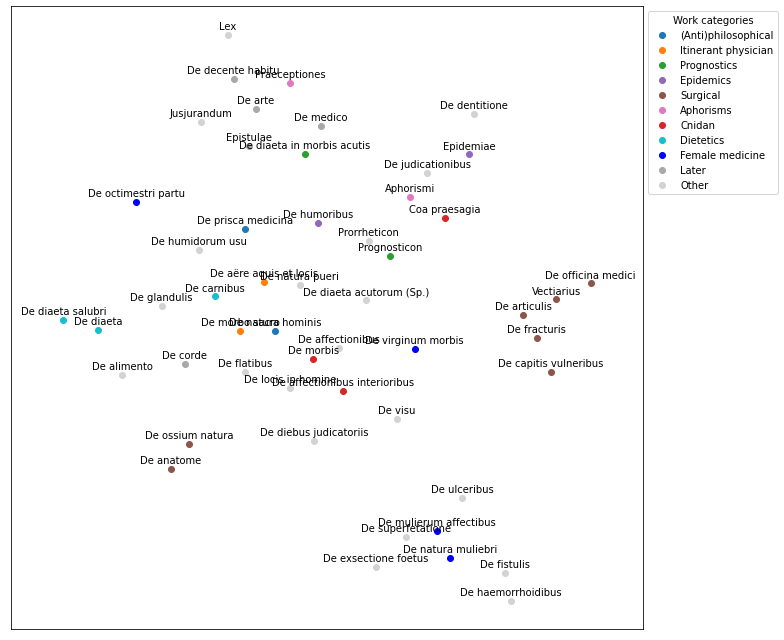

In [77]:
fig, ax = plt.subplots(figsize=(11,9), tight_layout=True)

work_colors = list(c_hippocraticum["work_cat_jouanna"].apply(lambda x: works_colors_dict[x]))


for x, y, name, color in zip(xs, ys, c_hip_vec[0].index, work_colors):
    ax.scatter(x, y, c=np.array([color]))
    #x = x- 0.06 #v(2 * len(name))
    ax.text(x, y + 0.01, name, horizontalalignment='center', fontsize=10)


ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_xlim(- 0.1, 1.1)
#title = "Corpus hippocraticum: Document distances based on vocabulary\n(work categories by Jouanna 1999)"
#ax.set_title(title)


markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_values]
plt.legend(markers, color_keys, numpoints=1,  title="Work categories", fontsize=10, bbox_to_anchor=(1,1), loc="upper left")

In [79]:
fig.savefig("../figures/c_hip_distances_by_cat_jouanna.png")

# Distances - work categories by Craik

In [80]:
color_keys = c_hippocraticum["work_cat_craik"].unique().tolist()
color_values = colors_list[:len(color_keys)]
works_colors_dict = dict(zip(color_keys, color_values))
works_colors_dict

{'Scientific principles': 'tab:blue',
 'Cases and signs': 'tab:orange',
 'Nosology, pathology, therapy': 'tab:green',
 'Surgery': 'tab:red',
 'Guidance and ideals': 'tab:purple',
 'Anatomy and physiology': 'tab:brown',
 'Gynaecology and embryology': 'tab:pink'}

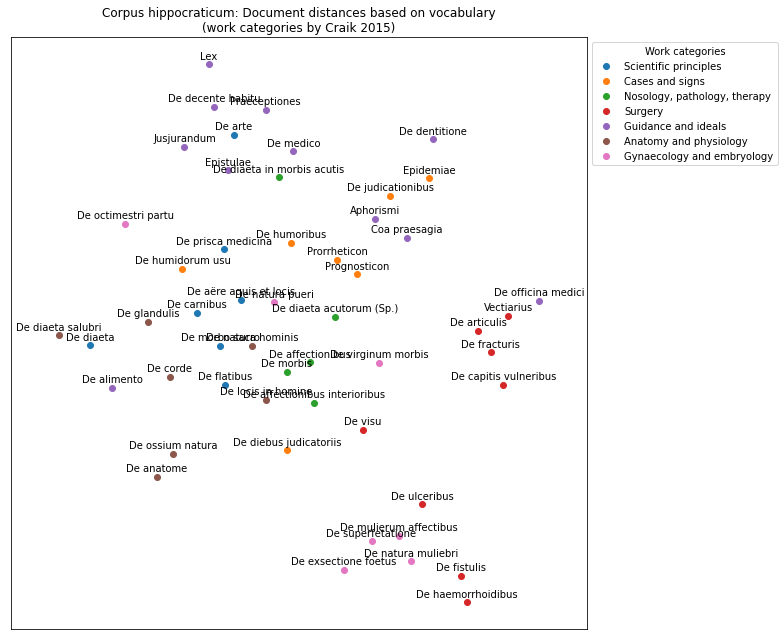

In [81]:
fig, ax = plt.subplots(figsize=(11,9), tight_layout=True)

work_colors = list(c_hippocraticum["work_cat_craik"].apply(lambda x: works_colors_dict[x]))


for x, y, name, color in zip(xs, ys, c_hip_vec[0].index, work_colors):
    ax.scatter(x, y, c=np.array([color]))
    #x = x- 0.06 #v(2 * len(name))
    ax.text(x, y + 0.01, name, horizontalalignment='center', fontsize=10)


ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_xlim(- 0.1, 1.1)
title = "Corpus hippocraticum: Document distances based on vocabulary\n(work categories by Craik 2015)"
ax.set_title(title)


markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_values]
plt.legend(markers, color_keys, numpoints=1,  title="Work categories", fontsize=10, bbox_to_anchor=(1,1), loc="upper left")

In [83]:
fig.savefig("../figures/c_hip_distances_by_cat_craik.png")

In [87]:
### also save the dataset with additional columns we created here

c_hippocraticum.to_json("../data/c_hippocraticum_enriched.json")